In [4]:
%reload_ext autoreload
%autoreload 2

In [5]:
import fastai
from fastai.vision import *
from pathlib import Path
from skimage.io import imread,imshow,imsave
import warnings
from collections import defaultdict
import pandas as pd

In [6]:
from tqdm import tqdm_notebook  as tqdm
import os
import gc
import torch
from fastai.vision.interpret import SegmentationInterpretation
import pickle

In [7]:
def clean_instance():
    gc.collect()
    torch.cuda.empty_cache()

In [8]:
os.sched_getaffinity(0)
os.cpu_count()

16

In [9]:
data_dir = Path('../train_rsz')
lbl_dir_fish = Path('../fish/lbl_fish_rsz')
lbl_dir_fish_det = Path('../fish/lbl_fish_det')
tst_dir = Path('../test_rsz')

In [10]:
df = pd.read_csv('../train.csv')

In [11]:
with open('fish_val_fls.pkl','rb') as fl:
    val_fls_fish = pickle.load(fl)

In [12]:
def valid_func(fn):
    return fn.name in val_fls_fish

In [13]:
# remove tranforms to predict on train_ds, 2225,556
# create null masks for no mask files
data1 = (SegmentationItemList.from_folder(data_dir)
        #.filter_by_rand(0.01)
       .split_by_valid_func(valid_func)
       .label_from_func(lambda l:lbl_dir_fish_det/(l.stem+".png"),classes=['bg','fish'])
        #.add_test(get_image_files(tst_dir))
       .transform(get_transforms(), tfm_y=True)
       .databunch(bs=8)
       .normalize(stats=imagenet_stats))

In [11]:
data_test = (SegmentationItemList.from_folder(data_dir)
        .filter_by_rand(0.01)
       .split_by_rand_pct()
       .label_from_func(lambda l:lbl_dir_fish/(l.stem+".png"),classes=['bg','fish'])
        .add_test(get_image_files(tst_dir))
       .transform(size=(350,525))
       .databunch(bs=12)
       .normalize(stats=imagenet_stats))

In [11]:
data1

ImageDataBunch;

Train: LabelList (4160 items)
x: SegmentationItemList
Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525)
y: SegmentationLabelList
ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525)
Path: ../train_rsz;

Valid: LabelList (1386 items)
x: SegmentationItemList
Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525),Image (3, 350, 525)
y: SegmentationLabelList
ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525),ImageSegment (1, 350, 525)
Path: ../train_rsz;

Test: None

# prepare learner

In [14]:
from fastai.metrics import dice

In [15]:
from fastai.callbacks import *
from torchvision.models import *
from mxresnet import *
from functools import partial
from ranger import *

In [16]:
def fit_with_annealing(learn:Learner, num_epoch:int, lr:float=defaults.lr, annealing_start:float=0.7)->None:
    n = len(learn.data.train_dl)
    anneal_start = int(n*num_epoch*annealing_start)
    phase0 = TrainingPhase(anneal_start).schedule_hp('lr', lr)
    phase1 = TrainingPhase(n*num_epoch - anneal_start).schedule_hp('lr', lr, anneal=annealing_cos)
    phases = [phase0, phase1]
    sched = GeneralScheduler(learn, phases)
    learn.callbacks.append(sched)
    learn.fit(num_epoch)

In [17]:
opt_func = partial(Ranger,  betas=(0.9,0.99), eps=1e-6)

In [18]:
from fastai.layers import CrossEntropyFlat

In [19]:
w = torch.tensor([1,2],dtype=torch.float32).to('cuda');
w

tensor([1., 2.], device='cuda:0')

In [20]:
learn = unet_learner(data1, resnet18,pretrained=True,metrics=[dice], wd=0.01, bottle=True,opt_func=opt_func,loss_func=CrossEntropyFlat(axis=1,weight=w)).to_fp16()

Using Ranger Optimizer...


In [185]:
learn.load('fc2');
#learn.load('../../train/models/fish15');

set state called


In [186]:
learn.unfreeze()

Using Ranger Optimizer...


In [125]:
learn.freeze()

Using Ranger Optimizer...


In [22]:
learn.lr_find()

Using Ranger Optimizer...


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


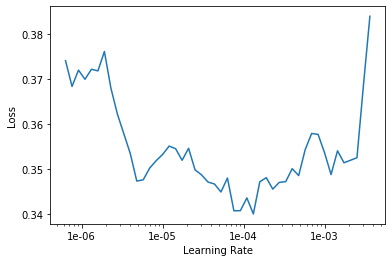

In [23]:
learn.recorder.plot()

In [187]:
fit_with_annealing(learn, 3, 0.001)

Using Ranger Optimizer...


epoch,train_loss,valid_loss,dice,time
0,0.148188,0.141956,0.291007,04:33
1,0.140045,0.120479,0.272824,04:34


In [51]:
learn.save("fc2")

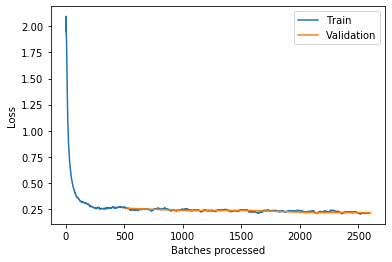

In [19]:
learn.recorder.plot_losses()

In [20]:
intrep = SegmentationInterpretation.from_learner(learn)

In [21]:
intrep._generate_confusion()[0]

array([[0.990691, 0.009309],
       [0.843673, 0.156327]], dtype=float32)

label,score
bg,0.990691
fish,0.156327


,label,score
0,bg,0.990691
1,fish,0.156327


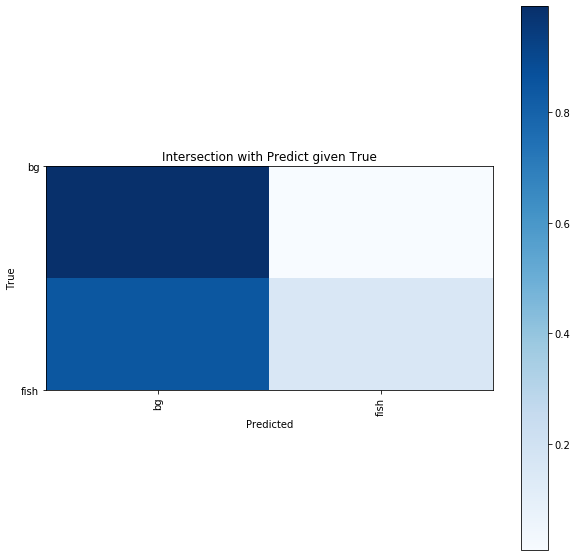

In [22]:
intrep._plot_intersect_cm(intrep.mean_cm)

## testing

In [212]:
xt,yt = learn.data.valid_ds[4]

In [213]:
yp = learn.predict(xt)

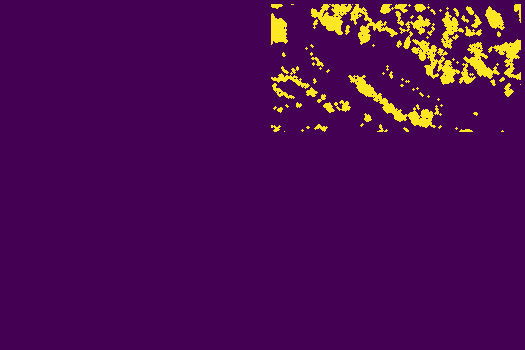

In [214]:
yt

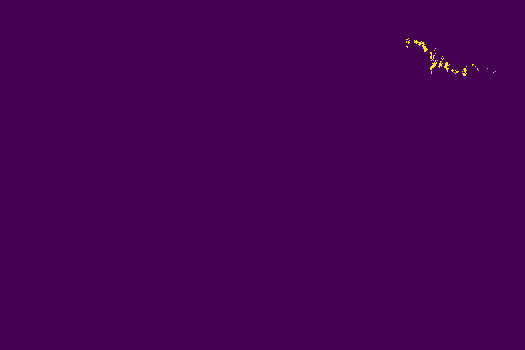

In [215]:
yp[0]

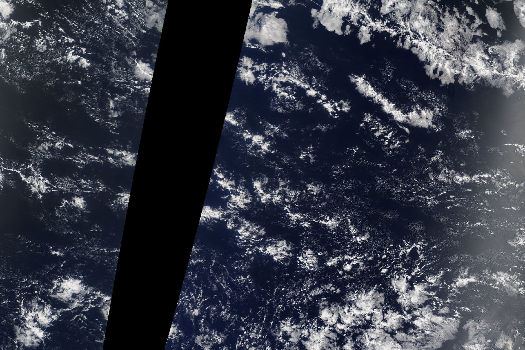

In [216]:
xt

# predict

In [22]:
preds = learn.get_preds(DatasetType.Test)

In [23]:
len(preds[0])

3698

In [24]:
preds[0][0].shape

torch.Size([2, 350, 525])

In [25]:
preds[1][0].shape

torch.Size([])

In [21]:
fls = learn.data.valid_ds.items

In [22]:
fls[:5]

array([PosixPath('../train/af268be.jpg'), PosixPath('../train/2e3ba6d.jpg'), PosixPath('../train/b8810ca.jpg'),
       PosixPath('../train/59121a5.jpg'), PosixPath('../train/23565eb.jpg')], dtype=object)

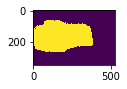

In [62]:
_ = 36
plt.figure(figsize=(10,1))
plt.imshow(torch.argmax(preds[0][_],dim=0).numpy())

In [27]:
preds_dir = Path('../preds/fish')
warnings.filterwarnings("ignore")

In [28]:
for num,pred in enumerate(tqdm(preds[0])):
    #msk = np.zeros((256,1600),dtype=np.uint8)
    msk = np.argmax(pred.numpy(),axis=0).astype(np.uint8)
    #save mask
    imsave(preds_dir/(learn.data.test_ds.items[num].stem+".png"),msk)

# create a  validation set

In [9]:
df_fish = df[::4]

In [10]:
# fish mask is preset data frame
df_fish_fish_present = df_fish.dropna()

In [11]:
fish_yes_fls = df_fish_fish_present.Image_Label.apply(lambda l:l.split("_")[0]).values

In [12]:
len(fish_yes_fls)

2781

In [13]:
all_files = df_fish.Image_Label.apply(lambda l: l.split("_")[0]).values

In [14]:
no_fish_fls = np.setdiff1d(all_files,fish_yes_fls)

In [15]:
len(no_fish_fls)+len(fish_yes_fls),len(all_files)

(5546, 5546)

In [16]:
no_fish_val_fls = np.random.choice(no_fish_fls,size=int(0.25*len(no_fish_fls)),replace=False)

In [17]:
yes_fish_val_fls = np.random.choice(fish_yes_fls,size=int(0.25*len(fish_yes_fls)),replace=False)

In [18]:
no_fish_trn_fls  = np.setdiff1d(no_fish_fls,no_fish_val_fls)
yes_fish_trn_fls = np.setdiff1d(fish_yes_fls,yes_fish_val_fls)

In [19]:
# check yes fish fls
assert(len(yes_fish_trn_fls)+len(yes_fish_val_fls) == len(fish_yes_fls))
assert(len(no_fish_trn_fls)+len(no_fish_val_fls) == len(no_fish_fls))

In [20]:
# save train files seperately
with open('yes_fish_trn_fls.pkl','wb') as fl:
    pickle.dump(yes_fish_trn_fls,fl)
with open('no_fish_trn_fls.pkl','wb') as fl:
    pickle.dump(no_fish_trn_fls,fl)
# save val files sepereately
with open('yes_fish_val_fls.pkl','wb') as fl:
    pickle.dump(yes_fish_val_fls,fl)
with open('no_fish_val_fls.pkl','wb') as fl:
    pickle.dump(no_fish_val_fls,fl)

In [21]:
# change file endings to png to match with resized files
val_set_files = np.union1d(yes_fish_val_fls,no_fish_val_fls)

In [23]:
func = np.vectorize(lambda l: l.replace('.jpg','.png',1))

In [24]:
val_set_files = func(val_set_files)

In [25]:
# save val files together
with open('fish_val_fls.pkl','wb') as fl:
    pickle.dump(val_set_files,fl)

In [25]:
# save val files together
with open('fish_val_fls.pkl','wb') as fl:
    pickle.dump(np.union1d(yes_fish_val_fls,no_fish_val_fls),fl)

# analyze preds

In [92]:
def_counts = {1:0,2:0,3:0,4:0}
def_fls = {1:[],2:[],3:[],4:[]}
for fl in learn.data.valid_ds.items:
    for i in [1,2,3,4]:
        if not pd.isna(df[df.ImageId_ClassId==fl.name+'_'+str(i)][df.columns[1]].values[0]):
            def_counts[i] += 1
            def_fls[i].append(fl)

In [93]:
def_counts

{1: 184, 2: 67, 3: 1011, 4: 160}

In [100]:
dice_scores = {'name':[],'m':[]}

In [17]:
def dice_from_msks(input, targs, iou=False, eps:float=1e-8):
    "Dice coefficient metric for binary target. If iou=True, returns iou metric, classic for segmentation problems."
    input = torch.argmax(input,dim=0)
    input = input.view(-1)
    targs = targs.view(-1)
    local = []
    for cat in [1,2,3,4]:
        input_ = (input == cat)
        targs_ = (targs == cat)
        intersect = (input_ * targs_).sum().float()
        union = (input_+targs_).sum().float()
        if not iou: l = 2. * intersect / union
        else: l = intersect / (union-intersect+eps)
        if union == 0:
            l = torch.tensor(0)
        local.append(l.item())

    return local

In [105]:
for fl in tqdm(learn.data.valid_ds.items):
    dice_scores['name'].append(fl.stem)
    fn = fl.stem+'.png'
    pred_nm = preds_dir/fn
    truth_nm = lbl_dir/fn
    p = imread(pred_nm)
    t = imread(truth_nm)
    dice_scores['m'].append(dice_from_msks(p,t))

TypeError: data type not understood

In [116]:
_ = imread(preds_dir/(learn.data.valid_ds.items[0].stem+'.png'))

In [117]:
_.shape

(128, 800)

# analyze the predictions

In [17]:
preds_val = learn.get_preds(DatasetType.Test)

In [19]:
preds_tst_pred = preds_val[0].numpy()
preds_tst_y = preds_val[1].numpy()

In [21]:
with open('preds_tst_pred.pkl','wb') as fl:
    pickle.dump(preds_tst_pred,fl,protocol=4)

In [22]:
with open('preds_val_pred.pkl','rb') as fl:
    preds_val_pred = pickle.load(fl)

In [24]:
with open('preds_tst_pred.pkl','rb') as fl:
    preds_tst_pred = pickle.load(fl)

MemoryError: 

In [25]:
#with open('preds_val_y.pkl','wb') as fl:
#    pickle.dump(preds_val_y,fl)

In [26]:
with open('preds_val_y.pkl','rb') as fl:
    preds_val_y = pickle.load(fl)

In [ ]:
with open('preds_tst_y.pkl','rb') as fl:
    preds_tst_y = pickle.load(fl)